In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import malaya_speech
from pysptk import sptk
import numpy as np
import tensorflow as tf

In [3]:
vggvox_v2 = malaya_speech.gender.deep_model(model = 'vggvox-v2')
speaker_model = malaya_speech.speaker_vector.deep_model('vggvox-v2')

In [4]:
freqs = {'female': [100, 600], 'male': [50, 250]}

In [5]:
from scipy.signal import get_window
from scipy import signal
import soundfile as sf
import random

sr = 22050

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

b, a = butter_highpass(30, sr, order=5)

In [6]:
from math import ceil

def speaker_normalization(f0, index_nonzero, mean_f0, std_f0):
    f0 = f0.astype(float).copy()
    f0[index_nonzero] = (f0[index_nonzero] - mean_f0) / std_f0
    f0[index_nonzero] = np.clip(f0[index_nonzero], -3, 4)
    return f0

def preprocess_wav(x):
    if x.shape[0] % 256 == 0:
        x = np.concatenate((x, np.array([1e-06])), axis=0)
    y = signal.filtfilt(b, a, x)
    wav = y * 0.96 + (np.random.uniform(size = y.shape[0]) - 0.5)*1e-06
    return wav

def get_f0(wav, lo, hi):
    f0_rapt = sptk.rapt(wav.astype(np.float32)*32768, sr, 256, min=lo, max=hi, otype=2)
    index_nonzero = (f0_rapt != -1e10)
    mean_f0, std_f0 = np.mean(f0_rapt[index_nonzero]), np.std(f0_rapt[index_nonzero])
    return speaker_normalization(f0_rapt, index_nonzero, mean_f0, std_f0)

def pad_seq(x, base = 8):
    len_out = int(base * ceil(float(x.shape[0]) / base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0, len_pad), (0, 0)), 'constant'), x.shape[0]

def get_speech(f, hop_size = 256):
    x, fs = malaya_speech.load(f, sr = sr)
    wav = preprocess_wav(x)
    lo, hi = freqs.get(vggvox_v2(x), [50, 250])
    f0 = np.expand_dims(get_f0(wav, lo, hi), -1)
    mel = malaya_speech.featurization.universal_mel(wav)
    
    batch_max_steps = random.randint(16384, 77175)
    batch_max_frames = batch_max_steps // hop_size
    
    if len(mel) > batch_max_frames:
        interval_start = 0
        interval_end = len(mel) - batch_max_frames
        start_frame = random.randint(interval_start, interval_end)
        start_step = start_frame * hop_size
        wav = wav[start_step : start_step + batch_max_steps]
        mel = mel[start_frame : start_frame + batch_max_frames, :]
        f0 = f0[start_frame : start_frame + batch_max_frames, :]
    
    mel, _ = pad_seq(mel)
    f0, _ = pad_seq(f0) 
        
    v = speaker_model([wav])[0]
    v = v / v.max()
    return wav, mel, f0, v

In [7]:
wav, mel, f0, v = get_speech('husein-zolkepli.wav')

In [8]:
wav_1, mel_1, f0_1, v_1 = get_speech('shafiqah-idayu.wav')

In [9]:
mels, mel_lens = malaya_speech.padding.sequence_nd([mel, mel_1], dim = 0, return_len = True)
mels.shape, mel_lens

((2, 256, 80), [128, 256])

In [10]:
f0s, f0_lens = malaya_speech.padding.sequence_nd([f0, f0_1], dim = 0, return_len = True)
f0s.shape, f0_lens

((2, 256, 1), [128, 256])

In [11]:
X = tf.placeholder(tf.float32, [None, None, 80])
len_X = tf.placeholder(tf.int32, [None])
V = tf.placeholder(tf.float32, [None, 512])
f0_onehot = tf.placeholder(tf.float32, [None, None, 257])
uttr_f0 = tf.placeholder(tf.float32, [None, None, 337])

In [12]:
from malaya_speech.train.model import speechsplit






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [13]:
hparams = speechsplit.hparams

model = speechsplit.Model(hparams)
model_F0 = speechsplit.Model_F0(hparams)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
bottleneck_speaker = tf.keras.layers.Dense(hparams.dim_spk_emb)
speaker_dim = bottleneck_speaker(V)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
def quantize_f0_numpy(x, num_bins = 256):
    assert x.ndim == 1
    x = x.astype(float).copy()
    uv = x <= 0
    x[uv] = 0.0
    x = np.round((x / np.max(x)) * (num_bins - 1))
    x = x + 1
    x[uv] = 0.0
    enc = np.zeros((len(x), num_bins + 1), dtype = np.float32)
    enc[np.arange(len(x)), x.astype(np.int32)] = 1.0
    return enc, x.astype(np.int64)

In [22]:
f0_org_quantized = quantize_f0_numpy(f0s[0,:,0])[0]
f0_org_onehot = f0_org_quantized[np.newaxis, :, :]
uttr_f0_org = np.concatenate([mels[:1], f0_org_onehot], axis = -1)

In [25]:
f0_trg_quantized = quantize_f0_numpy(f0s[1,:,0])[0]
f0_trg_onehot = f0_trg_quantized[np.newaxis, :, :]

In [27]:
f0_trg_onehot.shape

(1, 256, 257)

In [23]:
codes_x, codes_f0, codes_2, encoder_outputs, mel_outputs = model(uttr_f0, X, speaker_dim, training = False)

Tensor("speechsplit/Encoder_7/strided_slice:0", shape=(?, ?, 80), dtype=float32) Tensor("speechsplit/Encoder_7/strided_slice_1:0", shape=(?, ?, 257), dtype=float32)
Tensor("speechsplit/Encoder_7/strided_slice_4:0", shape=(?, ?, 512), dtype=float32) Tensor("speechsplit/Encoder_7/strided_slice_5:0", shape=(?, ?, 256), dtype=float32)
Tensor("speechsplit/Encoder_7/strided_slice_8:0", shape=(?, ?, 512), dtype=float32) Tensor("speechsplit/Encoder_7/strided_slice_9:0", shape=(?, ?, 256), dtype=float32)
(?, ?, 2)


In [24]:
_, _, _, f0_target = model_F0(X, f0_onehot, training = False)

(?, ?, 2)


In [29]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [30]:
saver = tf.train.Saver(var_list = tf.trainable_variables())
saver.restore(sess, 'speechsplit-vggvox-v2/model.ckpt-34000')

INFO:tensorflow:Restoring parameters from speechsplit-vggvox-v2/model.ckpt-34000


In [49]:
f0_pred = sess.run(f0_target, feed_dict = {
    X: mels[:1], f0_onehot: f0_trg_onehot
})

In [50]:
f0_pred_quantized = f0_pred.argmax(axis=-1).squeeze(0)
f0_con_onehot = np.zeros_like(f0_pred)
f0_con_onehot[0, np.arange(f0_pred.shape[1]), f0_pred_quantized] = 1
uttr_f0_trg = np.concatenate([mels[:1], f0_con_onehot], axis=-1)

In [51]:
# G(uttr_f0_org, uttr_trg_pad, emb_org)
x_identic_val_R = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_org,
                                                  X: mels[1:], V: [v]})
x_identic_val_R.shape

(1, 256, 80)

In [52]:
# G(uttr_f0_trg, uttr_org_pad, emb_org)
x_identic_val_F = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_trg,
                                                  X: mels[:1], V: [v]})
x_identic_val_F.shape

(1, 256, 80)

In [55]:
# G(uttr_f0_org, uttr_org_pad, emb_trg)
x_identic_val_U = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_org,
                                                  X: mels[:1], V: [v_1]})
x_identic_val_U.shape

(1, 256, 80)

In [56]:
# G(uttr_f0_trg, uttr_trg_pad, emb_org)
x_identic_val_RF = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_trg,
                                                  X: mels[1:], V: [v]})
x_identic_val_RF.shape

(1, 256, 80)

In [57]:
# G(uttr_f0_org, uttr_trg_pad, emb_trg)
x_identic_val_RU = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_org,
                                                  X: mels[1:], V: [v_1]})
x_identic_val_RU.shape

(1, 256, 80)

In [58]:
# G(uttr_f0_trg, uttr_org_pad, emb_trg)
x_identic_val_FU = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_trg,
                                                  X: mels[:1], V: [v_1]})
x_identic_val_FU.shape

(1, 256, 80)

In [59]:
# G(uttr_f0_trg, uttr_trg_pad, emb_trg)
x_identic_val_RFU = sess.run(mel_outputs, feed_dict = {uttr_f0: uttr_f0_trg,
                                                  X: mels[1:], V: [v_1]})
x_identic_val_RFU.shape

(1, 256, 80)

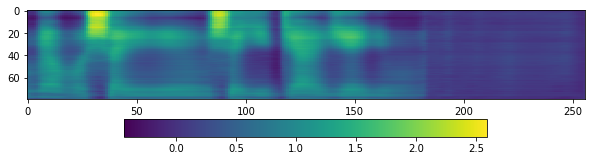

In [53]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_R[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

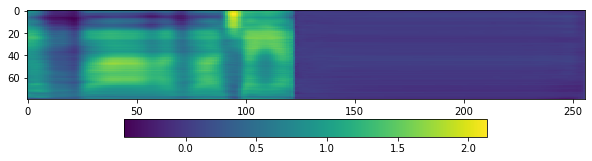

In [54]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_F[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

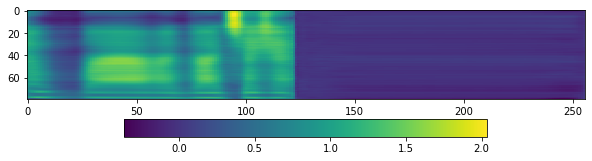

In [60]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_U[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

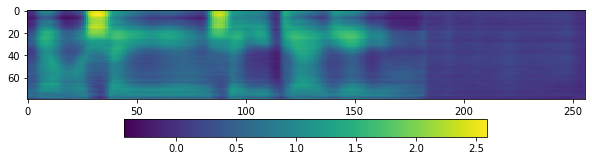

In [61]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_RF[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

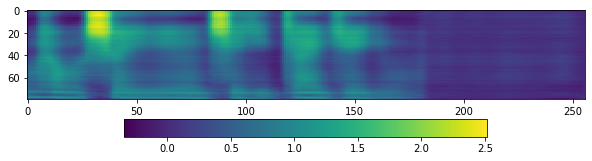

In [62]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_RU[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

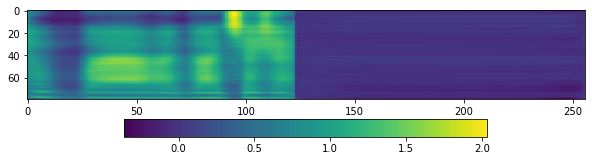

In [63]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_FU[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

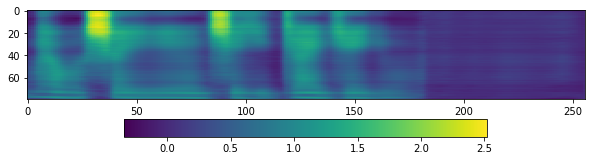

In [64]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(x_identic_val_RFU[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [65]:
import pickle

with open('a.pkl', 'wb') as fopen:
    pickle.dump([x_identic_val_R[0], x_identic_val_F[0], x_identic_val_U[0],
                x_identic_val_RF[0], x_identic_val_RU[0], x_identic_val_FU[0],
                x_identic_val_RFU[0]], fopen)